In [230]:
import numpy as np
import pandas as pd

In [231]:
#cluster visualization
#pull Z

Z = np.load("Z_latent.npy")  
df_best = pd.read_pickle("df_best.pkl")

In [232]:
#max k

max_k = df_best["Clusters"].max()


In [233]:
import matplotlib.pyplot as plt

base_cmap = plt.get_cmap("tab10")

cluster_colors = {
    cluster: base_cmap(cluster % 10)  
    for cluster in range(max_k)
}


In [234]:
from sklearn.manifold import TSNE

def plot_tsne_clusters_df_best(X, df_best, perplexity=30, random_state=42):

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    X_tsne = tsne.fit_transform(X)

    for _, row in df_best.iterrows():

        k = row["Clusters"]
        labels = row["Labels"] 

        point_colors = [cluster_colors[label] for label in labels]

        plt.figure(figsize=(8, 6))
        plt.title(f"t-SNE Visualization for Best Model (k={k}) - {row['Model']}", fontsize=14)

        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=point_colors, s=12)
        plt.xticks([])
        plt.yticks([])

        inertia_val = row.get("Inertia", None)
        inertia_str = "N/A" if inertia_val is None or (isinstance(inertia_val, float) and np.isnan(inertia_val)) else f"{inertia_val:.1f}"

        metrics_text = (
            f"Silhouette: {row['Silhouette']:.3f}\n"
            f"Davies-Bouldin: {row['DB']:.3f}\n"
            f"Calinski-Harabasz: {row['CH']:.1f}\n"
            f"Inertia: {inertia_str}\n"
            f"Params: {row['Params']}"
        )

        plt.text(
            0.02, 0.25, metrics_text,
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(facecolor="white", alpha=0.7)
        )

        plt.show()


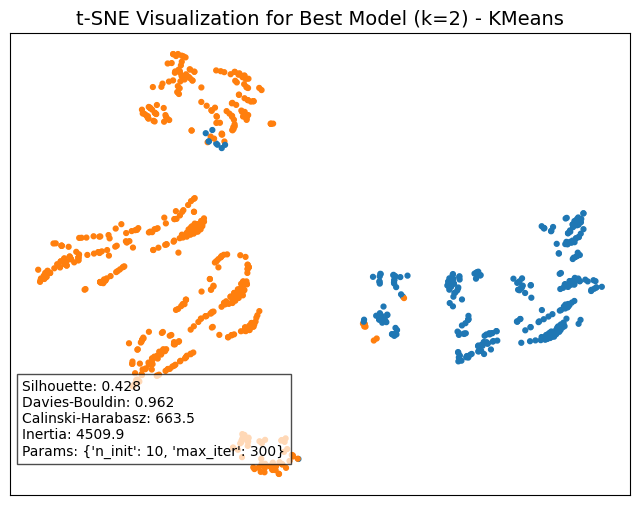

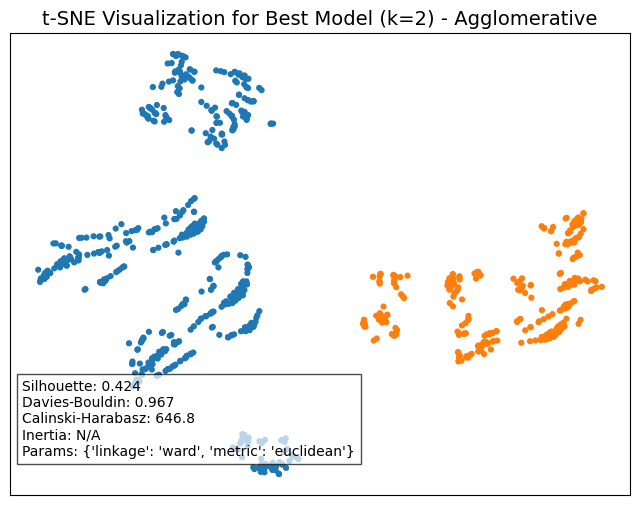

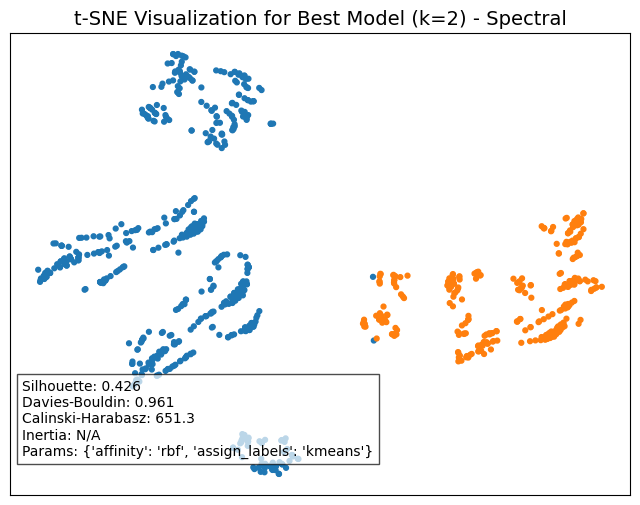

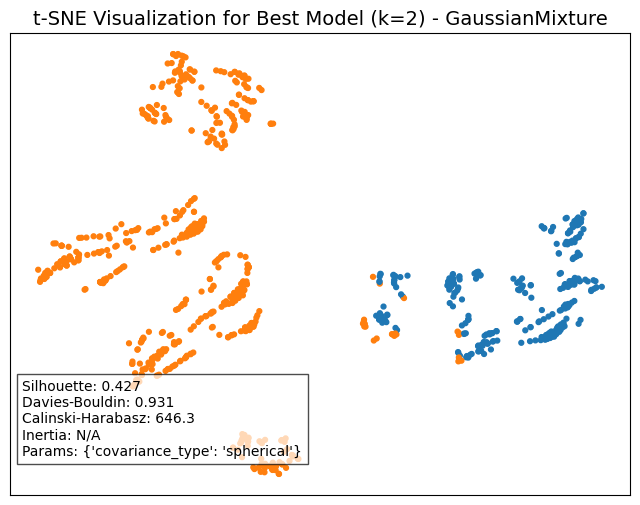

In [235]:
plot_tsne_clusters_df_best(Z,df_best)

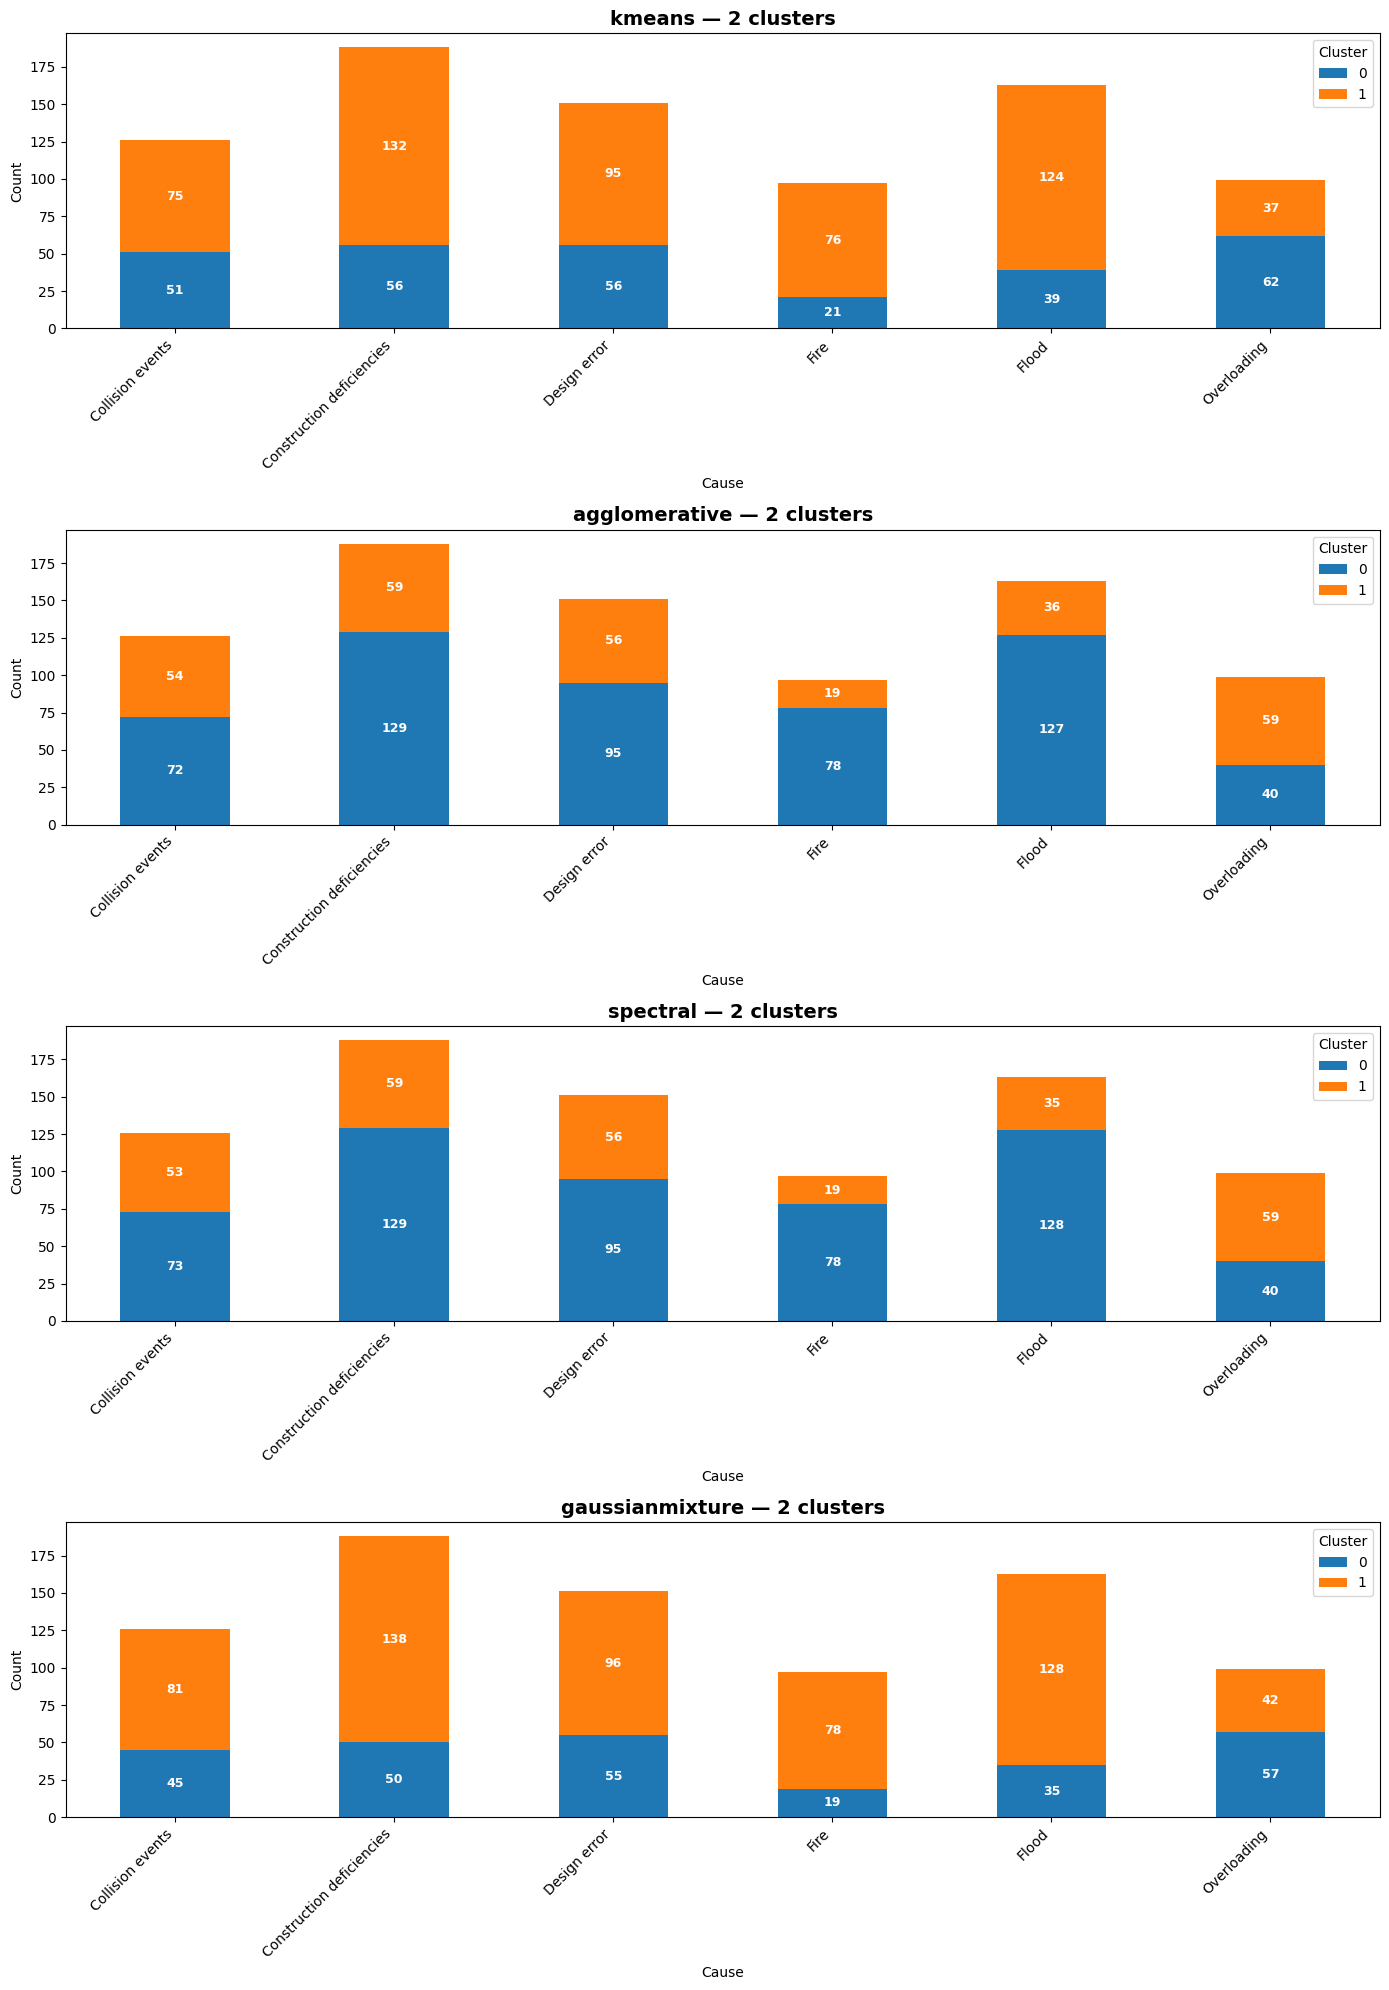

In [236]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Folder where you saved the CSVs
data_folder = r"E:\bridge_cause_analysis\Data\no_supervised_labeling"

max_k = df_best["Clusters"].max()
base_cmap = plt.get_cmap("tab10")

cluster_colors = {c: base_cmap(c % 10) for c in range(max_k)}

num_models = df_best.shape[0]
fig, axes = plt.subplots(num_models, 1, figsize=(14, 5 * num_models), sharex=False)

if num_models == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    model_name = str(df_best.loc[i, "Model"]).lower()
    k = int(df_best.loc[i, "Clusters"])

    filename = os.path.join(data_folder, f"{model_name}_k{k}.csv")
    model_df = pd.read_csv(filename)

    grouped = model_df.groupby(["Cause", "cluster"]).size().unstack(fill_value=0)

    colors = [cluster_colors[c] for c in grouped.columns]

    grouped.plot(kind="bar", stacked=True, color=colors, ax=ax)

    # --- moved inside loop ---
    ax.set_xlabel("Cause")
    ax.set_xticklabels(grouped.index, rotation=45, ha='right')

    # label counts
    for idx, cause in enumerate(grouped.index):
        y_offset = 0
        for cluster in grouped.columns:
            value = grouped.loc[cause, cluster]
            if value > 0:
                ax.text(
                    idx,
                    y_offset + value / 2,
                    str(value),
                    ha="center",
                    va="center",
                    fontsize=9,
                    color="white",
                    fontweight="bold"
                )
            y_offset += value

    ax.set_title(f"{model_name} — {k} clusters", fontsize=14, fontweight="bold")
    ax.set_ylabel("Count")
    ax.legend(title="Cluster", loc="upper right")

plt.tight_layout()
plt.show()


In [237]:
import os
import pandas as pd
import re

# Folder containing your {model_name}_k{k}.csv files
data_folder = r"E:\bridge_cause_analysis\Data\no_supervised_labeling"

# Will store: list of DataFrames, one per model
final_models_info = []

# Pattern: modelname_k3.csv   → captures ("modelname", "3")
pattern = re.compile(r"(.+)_k(\d+)\.csv")

# Scan all files in folder
files = [f for f in os.listdir(data_folder) if f.endswith(".csv")]

for filename in files:
    match = pattern.match(filename)
    if match:
        model_name = match.group(1)
        k_value = int(match.group(2))

        # Load CSV
        df = pd.read_csv(os.path.join(data_folder, filename))

        # Attach metadata (optional but useful)
        df["Model"] = model_name
        df["Clusters"] = k_value

        final_models_info.append(df)

# Sort results in consistent order (by model name then k)
final_models_info = sorted(
    final_models_info,
    key=lambda x: (x["Model"].iloc[0], x["Clusters"].iloc[0])
)

print(f"Loaded {len(final_models_info)} models from folder.")


Loaded 4 models from folder.


In [238]:
cluster_region_profiles = []

for i, model_df in enumerate(final_models_info):

    # Count regions per cluster
    counts = (
        model_df.groupby(["cluster", "Region"])
        .size()
        .reset_index(name="count")
    )

    cluster_region_profiles.append({
        "model_index": i,
        "raw_counts": counts
    })

print("cluster_region_profiles rebuilt with", len(cluster_region_profiles), "models.")


cluster_region_profiles rebuilt with 4 models.


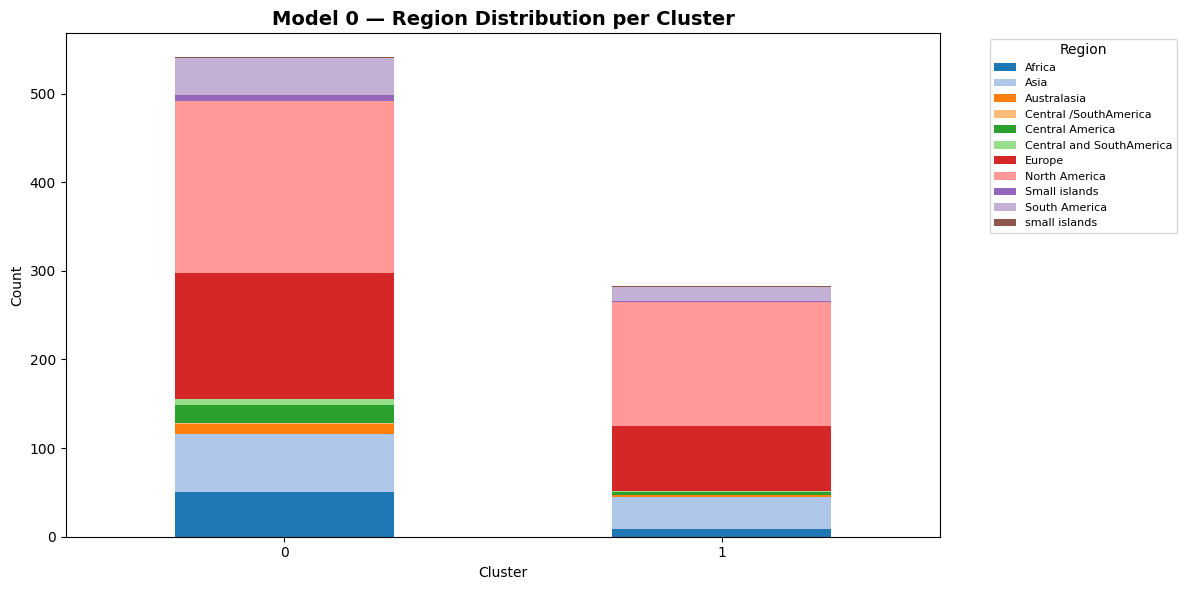

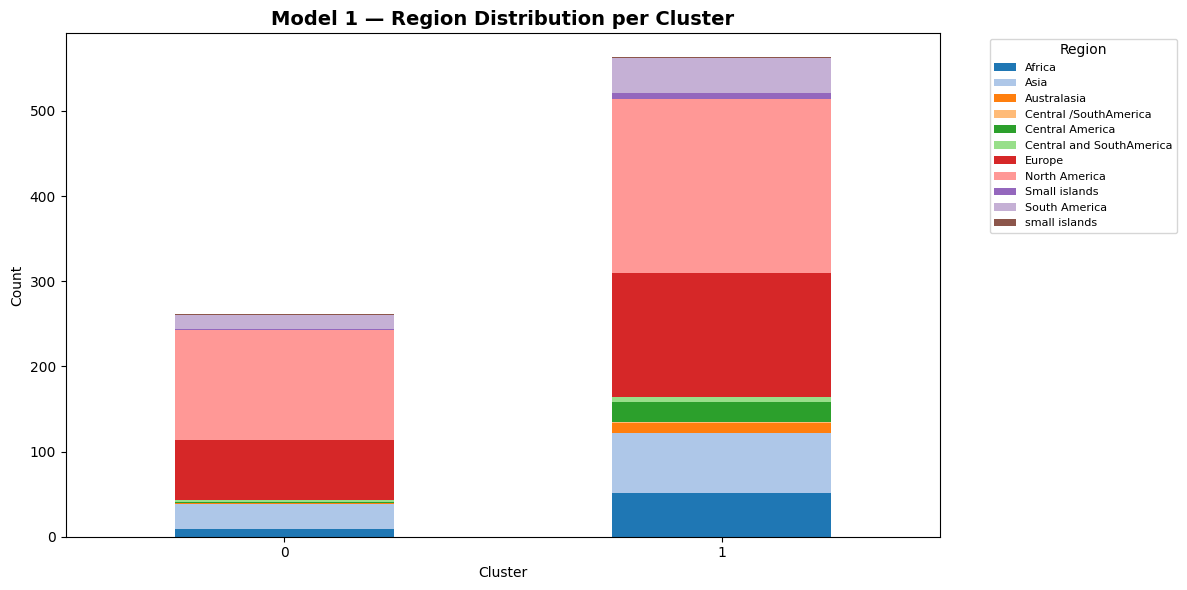

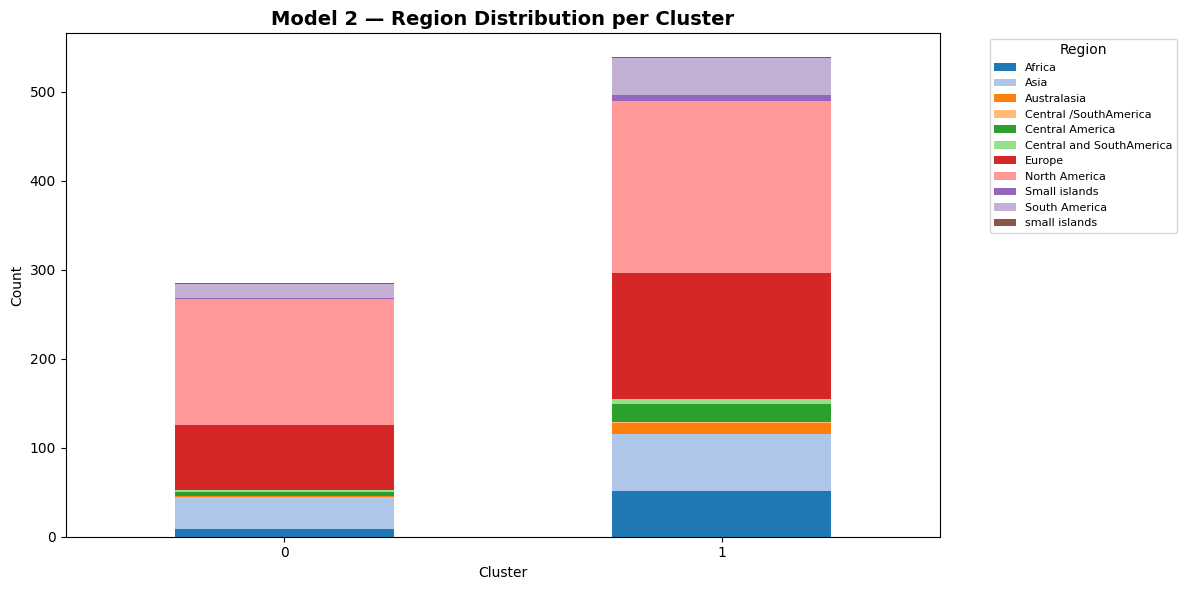

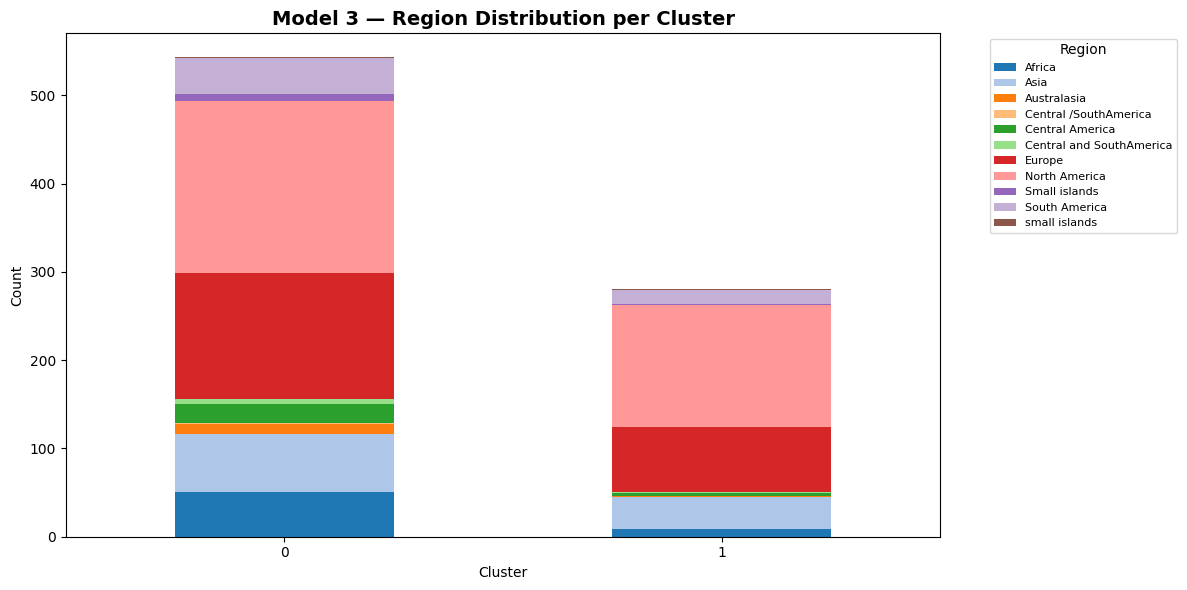

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Build consistent color map for all regions
unique_regions = sorted(
    set(sum([list(profile["raw_counts"]["Region"].unique()) 
            for profile in cluster_region_profiles], []))
)
palette = sns.color_palette("tab20", len(unique_regions))
color_map = {region: palette[i] for i, region in enumerate(unique_regions)}

for profile in cluster_region_profiles:

    model_index = profile["model_index"]
    df_counts = profile["raw_counts"]

    # Pivot table: clusters x regions
    pivot_df = df_counts.pivot(
        index="cluster",
        columns="Region",
        values="count"
    ).fillna(0)

    plt.figure(figsize=(12, 6))

    pivot_df.plot(
        kind="bar",
        stacked=True,
        color=[color_map[c] for c in pivot_df.columns],
        ax=plt.gca()
    )

    plt.title(f"Model {model_index} — Region Distribution per Cluster",
              fontsize=14, fontweight="bold")
    plt.xlabel("Cluster")
    plt.ylabel("Count")

    plt.legend(
        title="Region",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=8
    )

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


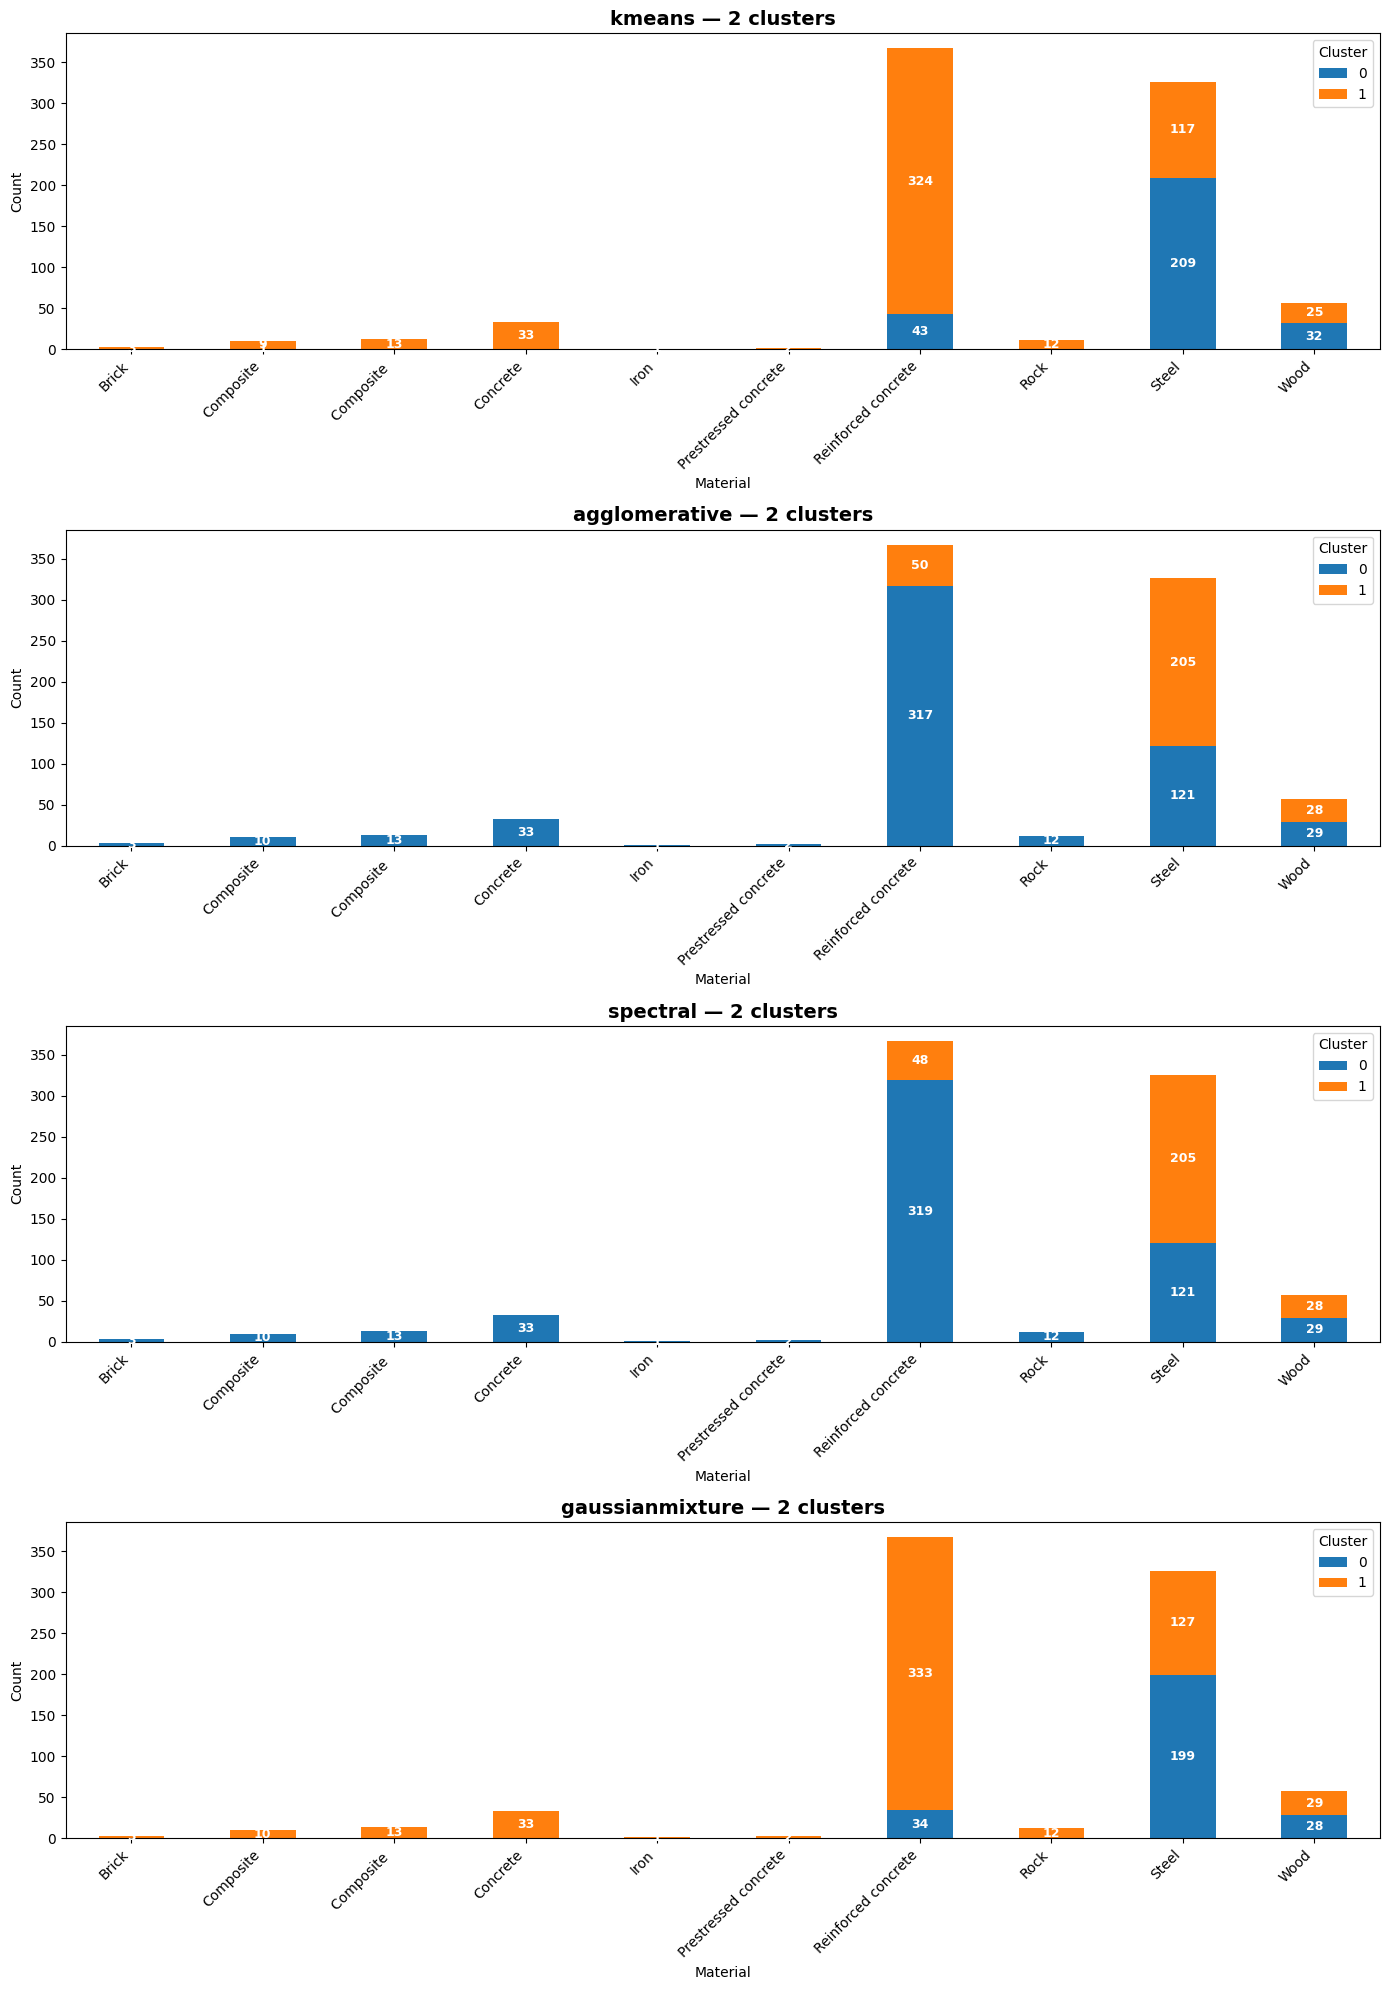

In [240]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Folder where you saved the CSVs
data_folder = r"E:\bridge_cause_analysis\Data\no_supervised_labeling"

max_k = df_best["Clusters"].max()
base_cmap = plt.get_cmap("tab10")

cluster_colors = {c: base_cmap(c % 10) for c in range(max_k)}

num_models = df_best.shape[0]
fig, axes = plt.subplots(num_models, 1, figsize=(14, 5 * num_models), sharex=False)

if num_models == 1:
    axes = [axes]

for i, ax in enumerate(axes):

    model_name = str(df_best.loc[i, "Model"]).lower()
    k = int(df_best.loc[i, "Clusters"])

    filename = os.path.join(data_folder, f"{model_name}_k{k}.csv")
    model_df = pd.read_csv(filename)

    # --- GROUP BY MATERIAL INSTEAD OF CAUSE ---
    grouped = model_df.groupby(["Material", "cluster"]).size().unstack(fill_value=0)

    # colors consistent by cluster
    colors = [cluster_colors[c] for c in grouped.columns]

    # stacked bar chart
    grouped.plot(kind="bar", stacked=True, color=colors, ax=ax)

    # x-axis labels
    ax.set_xlabel("Material")
    ax.set_xticklabels(grouped.index, rotation=45, ha='right')

    # add internal count labels
    for idx, material in enumerate(grouped.index):
        y_offset = 0
        for cluster in grouped.columns:
            value = grouped.loc[material, cluster]
            if value > 0:
                ax.text(
                    idx,
                    y_offset + value / 2,
                    str(value),
                    ha="center",
                    va="center",
                    fontsize=9,
                    color="white",
                    fontweight="bold"
                )
            y_offset += value

    # titles and axis labels
    ax.set_title(f"{model_name} — {k} clusters", fontsize=14, fontweight="bold")
    ax.set_ylabel("Count")
    ax.legend(title="Cluster", loc="upper right")

plt.tight_layout()
plt.show()


In [241]:
import os
import pandas as pd

# Folder containing your CSV files
folder_path = r"E:\bridge_cause_analysis\Data\no_supervised_labeling"

# Dictionary to store the DataFrames in memory
dfs = {}

for file in os.listdir(folder_path):
    if file.lower().endswith(".csv"):
        file_path = os.path.join(folder_path, file)
        df_name = os.path.splitext(file)[0]   # name without .csv
        dfs[df_name] = pd.read_csv(file_path)
        print(f"Loaded: {df_name}")

print("\nAll DataFrames loaded into memory:")
print(list(dfs.keys()))


Loaded: agglomerative_k2
Loaded: gaussianmixture_k2
Loaded: kmeans_k2
Loaded: spectral_k2

All DataFrames loaded into memory:
['agglomerative_k2', 'gaussianmixture_k2', 'kmeans_k2', 'spectral_k2']


In [242]:
import numpy as np
import matplotlib.pyplot as plt

def blend_multiple_colors(colors, weights):
    """
    Blend N RGBA colors using weights summing to 1.
    """
    colors = np.array(colors)
    weights = np.array(weights).reshape(-1, 1)
    blended = np.sum(colors * weights, axis=0)
    return tuple(blended)


def compute_material_colors(df_material, cluster_colors):
    """
    df_material must have:
      index = Material names
      columns = cluster names (0,1 or 0,1,2,...)
    
    Returns a dict:
      material -> blended RGBA color
    """
    material_colors = {}

    # Get cluster column names
    cluster_cols = [c for c in df_material.columns if isinstance(c, int) or c.isdigit()]

    for material, row in df_material.iterrows():
        weights_raw = row[cluster_cols].values.astype(float)
        weights_sum = weights_raw.sum()

        if weights_sum == 0:
            # default color if nothing
            material_colors[material] = (0.8,0.8,0.8,1)
            continue

        weights = weights_raw / weights_sum

        colors_to_blend = [cluster_colors[c] for c in cluster_cols]

        final_color = blend_multiple_colors(colors_to_blend, weights)
        material_colors[material] = final_color

    return material_colors


In [243]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_subregion_world_map(df, region_column="Region"):
    """
    World map colored by custom subregions.
    Uses Natural Earth 1:50m countries (official GeoPandas method).
    """

    # Download official Natural Earth countries dataset
    url = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
    countries = gpd.read_file(url)

    # Build mapping: country -> your Region/Subregion
    country_to_region = dict(zip(df["Country"], df[region_column]))

    # Some Natural Earth 'ADMIN' names may differ slightly
    countries["my_region"] = countries["ADMIN"].map(country_to_region)

    # Filter only countries that appear in your DataFrame
    highlight = countries[countries["my_region"].notna()].copy()

    # Plot base map (gray)
    fig, ax = plt.subplots(figsize=(14, 8))
    countries.plot(ax=ax, color="#EEEEEE", edgecolor="black", linewidth=0.3)

    # Highlighted regions
    highlight.plot(
        ax=ax,
        column="my_region",
        cmap="Set2",
        linewidth=0.8,
        edgecolor="black",
        legend=True
    )

    ax.set_title("Mapa Mundi – Subregiones Destacadas", fontsize=18)
    ax.set_axis_off()
    plt.show()


In [244]:
dfs['agglomerative_k2']['Region'].unique()

array(['Europe', 'Australasia', 'Asia', 'Africa', 'Central America',
       'North America', 'Central and SouthAmerica', 'South America',
       'small islands', 'Small islands', 'Central /SouthAmerica'],
      dtype=object)

In [245]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import pandas as pd

def plot_subregion_world_map_from_df(df, country_col="Country", region_col="Region"):
    """
    Plots a world map using ONLY the countries that appear in your DataFrame.
    df must have: country_col and region_col.
    Works with GeoPandas 1.0+ using geodatasets.
    """

    # Load modern GeoPandas world map
    world_path = geodatasets.get_path("naturalearth.land")  # 110m land polygons
    world = gpd.read_file(world_path)

    # The dataset only includes geometry; we need countries instead of continents
    # So load the proper Natural Earth admin_0 file:
    url = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip"
    world = gpd.read_file(url)

    # Column name depends on dataset
    if "ADMIN" in world.columns:
        world_name_col = "ADMIN"
    elif "name" in world.columns:
        world_name_col = "name"
    else:
        raise ValueError("No suitable country name column found in world dataset.")

    # Deduplicate your DF
    df_clean = df[[country_col, region_col]].drop_duplicates()

    # Merge your DF with world geometries
    merged = world.merge(df_clean, left_on=world_name_col, right_on=country_col, how="inner")

    if merged.empty:
        raise ValueError("No matching country names found between your DF and Natural Earth.")

    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    world.plot(ax=ax, color="#E6E6E6", edgecolor="black", linewidth=0.3)

    merged.plot(
        ax=ax,
        column=region_col,
        cmap="Set2",
        legend=True,
        linewidth=0.7,
        edgecolor="black"
    )

    ax.set_title("World Map – Custom Regions", fontsize=18)
    ax.set_axis_off()
    plt.show()


In [246]:
dfs['agglomerative_k2']

,Type,Cause,Material,Collapse,Status,Country,Region,Date,temperature_1.9,temperature_1.9.1,temperature_4.5,temperature_7.0,temperature_8.5,cluster
0,Beam,Collision events,Reinforced concrete,Total,Operational,Germany,Europe,1966,-0.36346,-0.306055,-0.24865,-0.225425,-0.24865,0
1,Truss,Collision events,Steel,Total,Operational,Germany,Europe,2015,0.96894,1.784090,1.65721,1.445855,1.41198,1
2,Truss,Collision events,Steel,Partial,Operational,Germany,Europe,1869,0.40503,0.348125,0.21938,0.244370,0.21938,1
3,Suspension,Collision events,Wood,Partial,Operational,Germany,Europe,1908,-0.37668,0.055205,-0.03791,-0.281860,-0.05782,1
4,Beam,Collision events,Reinforced concrete,Total,Operational,Germany,Europe,1979,-0.01883,0.183450,0.26149,0.136105,0.11345,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,Beam,Construction deficiencies,Reinforced concrete,Total,Construction,Jordan,Asia,2003,1.06424,0.899050,1.01453,1.045700,1.01453,0
820,Beam,Flood,Composite,Partial,Operational,Lesotho,Africa,2020,1.67965,1.289420,1.18791,1.369190,1.30962,0
821,Beam,Flood,Reinforced concrete,Total,Operational,Liberia,Africa,2025,1.57352,1.523960,1.32506,1.351885,1.60314,0
822,Beam,Construction deficiencies,Composite,Total,Operational,Mexico,North America,2022,1.42284,1.466040,1.65549,1.288590,1.42562,0


In [247]:
base_cmap = plt.get_cmap("tab10")

df_mat=dfs['agglomerative_k2']

max_k = df_mat.shape[1]   # number of cluster columns
cluster_colors = {
    k: base_cmap(k % 10)
    for k in range(max_k)
}



In [248]:
material_colors = compute_material_colors(df_mat, cluster_colors)


In [249]:
import numpy as np
import matplotlib.pyplot as plt

def blend_multiple_colors(colors, weights):
    colors = np.array(colors)
    weights = np.array(weights).reshape(-1, 1)
    blended = np.sum(colors * weights, axis=0)
    return tuple(blended)

def compute_material_colors(df_material, cluster_colors):
    material_colors = {}

    # detect cluster columns
    cluster_cols = [c for c in df_material.columns if isinstance(c, int) or str(c).isdigit()]

    for material, row in df_material.iterrows():
        weights_raw = row[cluster_cols].values.astype(float)
        if weights_raw.sum() == 0:
            material_colors[material] = (0.7,0.7,0.7,1)
            continue

        weights = weights_raw / weights_raw.sum()
        colors_to_blend = [cluster_colors[int(c)] for c in cluster_cols]
        material_colors[material] = blend_multiple_colors(colors_to_blend, weights)

    return material_colors


In [250]:
df_bridges=dfs['agglomerative_k2']

In [251]:
import geopandas as gpd

def load_world_map_shp(path_to_shp):
    world = gpd.read_file(path_to_shp)
    world = world.rename(columns={"ADMIN": "Country", "SOVEREIGNT": "Sovereignty"})
    return world


In [252]:
world = load_world_map_shp(r"E:\bridge_cause_analysis\Graph\ne_110m_admin_0_countries.shp")


In [253]:
df_plot = df_bridges[["Country", "Material"]]
df_plot["Country"] = df_plot["Country"].str.strip()

world_plot = world.merge(df_plot, on="Country", how="left")


C:\Users\Elias\AppData\Local\Temp\ipykernel_16444\2967541157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["Country"] = df_plot["Country"].str.strip()


In [254]:

# --------------------------------------------------------
# 2. Function to blend cluster colors based on percentages
# --------------------------------------------------------
def blend_color(colors, weights):
    """Blend list of RGB colors using given weights (0–1)."""
    colors = np.array(colors)
    weights = np.array(weights).reshape(-1, 1)
    blended = np.sum(colors * weights, axis=0)
    return tuple(blended)


# ----------------------------------------------------------
# 3. Plot world map for a specific material with blend color
# ----------------------------------------------------------
def plot_material_map(world, df_bridges, material_table, material_name, cluster_colors):
    """
    world: GeoDataFrame of world polygons
    df_bridges: your full bridge dataset (contains Country + Material)
    material_table: your cluster-percentage table for this material
    material_name: string, the material to highlight
    cluster_colors: dict {cluster_id: (r,g,b,a)}
    """

    # Filter countries that use the material
    df_mat = df_bridges[df_bridges["Material"] == material_name][["Country", "Material"]].copy()
    df_mat["Country"] = df_mat["Country"].str.strip()

    # Add cluster-percentage info
    df_mat = df_mat.merge(material_table, left_on="Material", right_index=True, how="left")

    # Attach to world map
    merged = world.merge(df_mat, on="Country", how="left")

    # Prepare blended colors
    blended_colors = []
    for _, row in merged.iterrows():
        if pd.isna(row["Material"]):
            blended_colors.append((0.85, 0.85, 0.85, 1))  # gray for "no data"
        else:
            # Extract cluster % for this material
            weights = np.array([row[c] for c in material_table.columns]) / 100.0
            # Corresponding cluster colors
            cols = [cluster_colors[c] for c in material_table.columns]
            blended_colors.append(blend_color(cols, weights))

    # Plot
    fig, ax = plt.subplots(figsize=(16, 10))
    merged.plot(ax=ax, color=blended_colors, edgecolor="black", linewidth=0.5)

    ax.set_title(f"Material: {material_name} – Cluster Contribution Map", fontsize=18)
    ax.set_axis_off()

    plt.show()


# --------------------------------------------------------
# 4. Example usage
# --------------------------------------------------------

# Assuming your cluster colors are:
# (already provided earlier)
# Example: base 10 colors
import matplotlib.pyplot as plt
base_cmap = plt.get_cmap("tab10")

# max_k = number of clusters in your dataset
max_k = 2  # you can replace
cluster_colors = {i: base_cmap(i % 10) for i in range(max_k)}

# MATERIAL TABLE example (replace with your variable)
# material_table = df_material_distribution   # <- your real variable

# Example call:
# plot_material_map(world, df_bridges, material_table, "Steel", cluster_colors)


In [255]:
dfs['agglomerative_k2']

,Type,Cause,Material,Collapse,Status,Country,Region,Date,temperature_1.9,temperature_1.9.1,temperature_4.5,temperature_7.0,temperature_8.5,cluster
0,Beam,Collision events,Reinforced concrete,Total,Operational,Germany,Europe,1966,-0.36346,-0.306055,-0.24865,-0.225425,-0.24865,0
1,Truss,Collision events,Steel,Total,Operational,Germany,Europe,2015,0.96894,1.784090,1.65721,1.445855,1.41198,1
2,Truss,Collision events,Steel,Partial,Operational,Germany,Europe,1869,0.40503,0.348125,0.21938,0.244370,0.21938,1
3,Suspension,Collision events,Wood,Partial,Operational,Germany,Europe,1908,-0.37668,0.055205,-0.03791,-0.281860,-0.05782,1
4,Beam,Collision events,Reinforced concrete,Total,Operational,Germany,Europe,1979,-0.01883,0.183450,0.26149,0.136105,0.11345,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,Beam,Construction deficiencies,Reinforced concrete,Total,Construction,Jordan,Asia,2003,1.06424,0.899050,1.01453,1.045700,1.01453,0
820,Beam,Flood,Composite,Partial,Operational,Lesotho,Africa,2020,1.67965,1.289420,1.18791,1.369190,1.30962,0
821,Beam,Flood,Reinforced concrete,Total,Operational,Liberia,Africa,2025,1.57352,1.523960,1.32506,1.351885,1.60314,0
822,Beam,Construction deficiencies,Composite,Total,Operational,Mexico,North America,2022,1.42284,1.466040,1.65549,1.288590,1.42562,0


# Mapa Mundi

In [256]:
dfs['agglomerative_k2']['Country'].unique()
import geopandas as gpd
import pandas as pd

# Natural Earth URL
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

name_col = "ADMIN" if "ADMIN" in world.columns else "NAME"

def check_country_matches(df, country_col="Country"):
    df = df.copy()
    df[country_col] = df[country_col].str.strip()

    world_names = set(world[name_col].str.strip())
    df_names = set(df[country_col].str.strip())

    missing = sorted(df_names - world_names)
    extra = sorted(world_names - df_names)

    print("=== Countries NOT recognized by NaturalEarth ===")
    for m in missing:
        print("  -", m)

    print("\n=== Countries present in NaturalEarth but not in your DF ===")
    print("(only for reference)")
    for e in extra[:30]:   # avoid flooding output
        print("  -", e)

    return missing

missing = check_country_matches(df)


=== Countries NOT recognized by NaturalEarth ===
  - Afganistan
  - Andorra
  - Bahamas
  - Barein
  - Burkina
  - Buthan
  - Cabo Verde
  - Camerun
  - Corea
  - Cote d'Ivoire
  - Dominicana
  - Emiratos arabes unidos
  - Eswatini
  - Fiyi
  - Gambiia
  - Grenada
  - Guyana Francesa
  - Hungria
  - Islas Salomon
  - Japon
  - Liechtenstein
  - Macedonia
  - Mauritius
  - Moroco
  - Nauru
  - Paises Bajos
  - Palau
  - Republica Checa
  - Republica Democratica del Congo
  - Rumania
  - Serbia
  - Seychelles
  - Sierra Lona
  - Singapore
  - Sudan del sur
  - Tanzania
  - Tunez
  - USA

=== Countries present in NaturalEarth but not in your DF ===
(only for reference)
  - Afghanistan
  - Antarctica
  - Armenia
  - Bhutan
  - Bosnia and Herzegovina
  - Bulgaria
  - Burkina Faso
  - Colombia
  - Costa Rica
  - Cuba
  - Cyprus
  - Czechia
  - Democratic Republic of the Congo
  - Djibouti
  - East Timor
  - El Salvador
  - Equatorial Guinea
  - Eritrea
  - Ethiopia
  - Falkland Islands
  - F

In [257]:
country_fix = {
    "Afganistan": "Afghanistan",
    "Andorra": "Andorra",
    "Bahamas": "The Bahamas",
    "Barein": "Bahrain",
    "Burkina": "Burkina Faso",
    "Buthan": "Bhutan",
    "Cabo Verde": "Cape Verde",
    "Camerun": "Cameroon",
    "Corea": "Korea, Republic of South Korea",  
    "Cote d'Ivoire": "Ivory Coast",
    "Dominicana": "Dominican Republic",
    "Emiratos arabes unidos": "United Arab Emirates",
    "Eswatini": "eSwatini",
    "Fiyi": "Fiji",
    "Gambiia": "The Gambia",
    "Grenada": "Grenada",
    "Guyana Francesa": "French Guiana",
    "Hungria": "Hungary",
    "Islas Salomon": "Solomon Islands",
    "Japon": "Japan",
    "Liechtenstein": "Liechtenstein",
    "Macedonia": "North Macedonia",
    "Mauritius": "Mauritius",
    "Moroco": "Morocco",
    "Nauru": "Nauru",
    "Paises Bajos": "Netherlands",
    "Palau": "Palau",
    "Republica Checa": "Czechia",
    "Republica Democratica del Congo": "Democratic Republic of the Congo",
    "Rumania": "Romania",
    "Serbia": "Serbia",
    "Seychelles": "Seychelles",
    "Sierra Lona": "Sierra Leone",
    "Singapore": "Singapore",
    "Sudan del sur": "South Sudan",
    "Tanzania": "Tanzania",
    "Tunez": "Tunisia",
    "USA": "United States of America",

    "Andorra": "Andorra",
    "Bahamas": "Bahamas",
    "Bahrain": "Bahrain",
    "Cape Verde": "Cape Verde",
    "French Guiana": "French Guiana",
    "Gambia, The": "Gambia, The",
    "Grenada": "Grenada",
    "Korea, Republic of": "Korea, South",
    "South Korea": "Korea, South",
    "Liechtenstein": "Liechtenstein",
    "Mauritius": "Mauritius",
    "Nauru": "Nauru",
    "Palau": "Palau",
    "Serbia": "Serbia",
    "Seychelles": "Seychelles",
    "Singapore": "Singapore",
    "Tanzania": "Tanzania",
    "Tunez": "Tunisia"
}


In [258]:
for name, df in dfs.items():
    df["Country"] = df["Country"].replace(country_fix)


In [259]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Point

def plot_clusters_world_map_swarm(df, country_col="Country", cluster_col="cluster", samples_per_point=200):
    """
    Generates a swarm of points INSIDE the actual country polygon.
    Uses rejection sampling to ensure each point lies within the borders.

    df: your dataframe
    country_col: name of the column containing country names
    cluster_col: name of the cluster column
    samples_per_point: number of attempts per point (more = denser but slower)
    """

    # ---- Load world map ----
    url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)

    name_col = "ADMIN" if "ADMIN" in world.columns else "NAME"

    df = df.copy()
    df[country_col] = df[country_col].str.strip()

    # ---- Build polygon lookup ----
    polygon_map = world.set_index(name_col)["geometry"]

    # ---- Store generated points ----
    swarm_points = []

    for country, group in df.groupby(country_col):
        if country not in polygon_map.index:
            print(f"Skipping (not in map): {country}")
            continue

        poly = polygon_map[country]

        # If multiple polygons (e.g. France), unify
        if poly.geom_type == "MultiPolygon":
            poly = max(poly.geoms, key=lambda a: a.area)

        minx, miny, maxx, maxy = poly.bounds

        needed = len(group)
        pts = []

        # Rejection sampling
        attempts = 0
        while len(pts) < needed and attempts < samples_per_point * needed:
            attempts += 1
            x = np.random.uniform(minx, maxx)
            y = np.random.uniform(miny, maxy)
            p = Point(x, y)
            if poly.contains(p):
                pts.append(p)

        if len(pts) < needed:
            print(f"⚠ Warning: Only placed {len(pts)}/{needed} inside {country}")

        swarm_points.extend(pts)

    # ---- Assign geometry ----
    df = df.iloc[:len(swarm_points)].copy()
    df["geometry"] = swarm_points
    gdf_points = gpd.GeoDataFrame(df, geometry="geometry", crs=world.crs)

    # ---- Coloring ----
    max_k = df[cluster_col].max() + 1
    cmap = plt.get_cmap("tab10")
    cluster_colors = {c: cmap(c % 10) for c in range(max_k)}

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(14, 8))

    world.plot(ax=ax, color="#EFEFEF", edgecolor="black", linewidth=0.3)

    for c, color in cluster_colors.items():
        gdf_points[gdf_points[cluster_col] == c].plot(
            ax=ax,
            color=color,
            markersize=5,
            alpha=0.9,
            label=f"Cluster {c}"
        )

    ax.set_title("Country-Bounded Swarm Layout", fontsize=18)
    ax.set_axis_off()
    ax.legend()
    plt.show()


Skipping (not in map): Andorra
Skipping (not in map): Bahamas
Skipping (not in map): Bahrain
Skipping (not in map): Cape Verde
Skipping (not in map): French Guiana
Skipping (not in map): Grenada
Skipping (not in map): Korea, Republic of South Korea
Skipping (not in map): Liechtenstein
Skipping (not in map): Mauritius
Skipping (not in map): Nauru
Skipping (not in map): Palau
Skipping (not in map): Serbia
Skipping (not in map): Seychelles
Skipping (not in map): Singapore
Skipping (not in map): Tanzania
Skipping (not in map): The Gambia
Skipping (not in map): Tunez


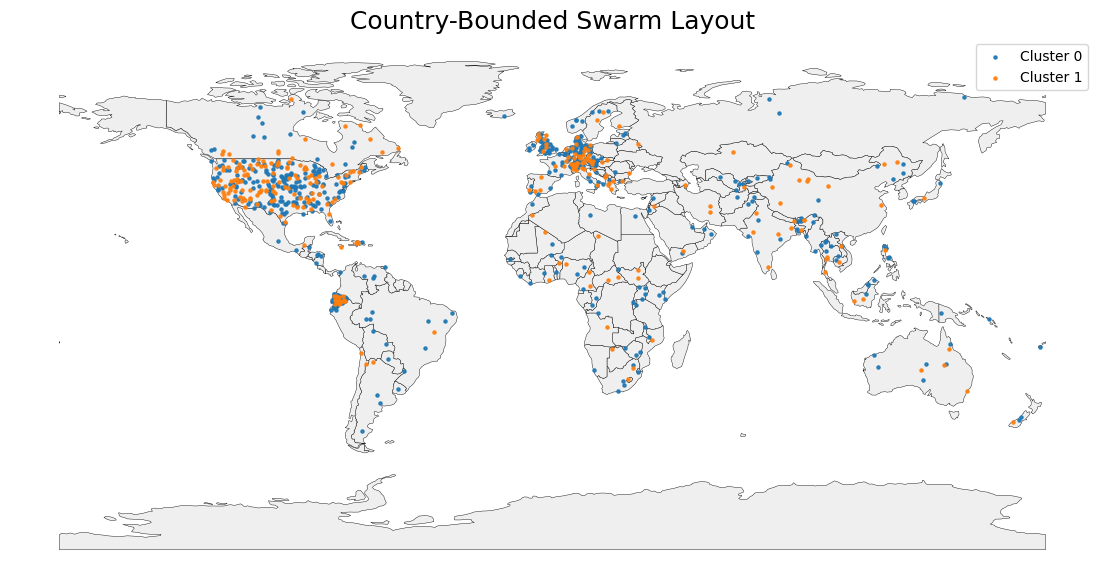

In [260]:
plot_clusters_world_map_swarm(dfs["agglomerative_k2"])


In [261]:
dfs['agglomerative_k2']['Country'].unique()
import geopandas as gpd
import pandas as pd

# Natural Earth URL
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

name_col = "ADMIN" if "ADMIN" in world.columns else "NAME"

def check_country_matches(df, country_col="Country"):
    df = df.copy()
    df[country_col] = df[country_col].str.strip()

    world_names = set(world[name_col].str.strip())
    df_names = set(df[country_col].str.strip())

    missing = sorted(df_names - world_names)
    extra = sorted(world_names - df_names)

    print("=== Countries NOT recognized by NaturalEarth ===")
    for m in missing:
        print("  -", m)

    print("\n=== Countries present in NaturalEarth but not in your DF ===")
    print("(only for reference)")
    for e in extra[:30]:   # avoid flooding output
        print("  -", e)

    return missing

missing = check_country_matches(df)


=== Countries NOT recognized by NaturalEarth ===
  - Andorra
  - Bahamas
  - Bahrain
  - Cape Verde
  - French Guiana
  - Grenada
  - Korea, Republic of South Korea
  - Liechtenstein
  - Mauritius
  - Nauru
  - Palau
  - Serbia
  - Seychelles
  - Singapore
  - Tanzania
  - The Gambia
  - Tunez

=== Countries present in NaturalEarth but not in your DF ===
(only for reference)
  - Antarctica
  - Armenia
  - Bosnia and Herzegovina
  - Bulgaria
  - Colombia
  - Costa Rica
  - Cuba
  - Cyprus
  - Djibouti
  - East Timor
  - El Salvador
  - Equatorial Guinea
  - Eritrea
  - Ethiopia
  - Falkland Islands
  - French Southern and Antarctic Lands
  - Gabon
  - Gambia
  - Georgia
  - Greenland
  - Guatemala
  - Guinea
  - Guinea-Bissau
  - Guyana
  - Iraq
  - Kosovo
  - Kuwait
  - Lebanon
  - Madagascar
  - Mauritania


# Graphs

In [262]:
for name,df in dfs.items():
    df['Material'] = df['Material'].str.strip() 

In [263]:
columns=dfs['kmeans_k2'].columns
columns

Index(['Type', 'Cause', 'Material', 'Collapse', 'Status', 'Country', 'Region',
       'Date', 'temperature_1.9', 'temperature_1.9.1', 'temperature_4.5',
       'temperature_7.0', 'temperature_8.5', 'cluster'],
      dtype='object')

In [290]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_cluster_participation(df, feature_col, cluster_col="cluster"):

    # Count feature occurrences per cluster
    table = (
        df.groupby([feature_col, cluster_col])
          .size()
          .reset_index(name="count")
    )

    # Pivot to wide format
    pivot = (
        table.pivot(index=feature_col, columns=cluster_col, values="count")
             .fillna(0)
    )

    # Convert counts to percentages
    percent = pivot.div(pivot.sum(axis=1), axis=0) * 100

    print(f"\n=== Percentage Participation of '{feature_col}' per Cluster ===\n")
    print(percent.round(2))

    # # Plot
    # ax = percent.plot(
    #     kind="bar",
    #     stacked=True,
    #     figsize=(12, 7),
    #     edgecolor="black"
    # )

    # plt.title(f"{feature_col} Participation Across Clusters", fontsize=16)
    # plt.ylabel("Percentage (%)", fontsize=14)
    # plt.xlabel(feature_col, fontsize=14)
    # plt.legend(title=cluster_col, bbox_to_anchor=(1.02, 1), loc="upper left")

    # # --- ADD PERCENTAGE LABELS ON THE BARS ---
    # for container in ax.containers:
    #     # Each container is a stack segment for one cluster
    #     ax.bar_label(
    #         container,
    #         fmt="%.1f%%",
    #         label_type="center",   # place inside segment
    #         padding=0,
    #     )

    # plt.tight_layout()
    # plt.show()

    return percent


In [291]:
columns

Index(['Type', 'Cause', 'Material', 'Collapse', 'Status', 'Country', 'Region',
       'Date', 'temperature_1.9', 'temperature_1.9.1', 'temperature_4.5',
       'temperature_7.0', 'temperature_8.5', 'cluster'],
      dtype='object')

In [292]:
models = {}
cat_cols = ['Type', 'Cause', 'Material', 'Collapse', 'Status']

for name, df in dfs.items():
    print('\n' * 10 + "=======================" + str(name).upper() + "=======================")

    model_tables = {}

    for col in cat_cols:
        model_tables[col] = visualize_cluster_participation(df, col)

    models[name] = model_tables












=======================AGGLOMERATIVE_K2=======================

=== Percentage Participation of 'Type' per Cluster ===

cluster            0       1
Type                        
Arch          100.00    0.00
Beam          100.00    0.00
Cable-stayed  100.00    0.00
Slab           80.00   20.00
Suspension      3.64   96.36
Trestle         0.00  100.00
Truss           4.70   95.30

=== Percentage Participation of 'Cause' per Cluster ===

cluster                        0      1
Cause                                  
Collision events           57.14  42.86
Construction deficiencies  68.62  31.38
Design error               62.91  37.09
Fire                       80.41  19.59
Flood                      77.91  22.09
Overloading                40.40  59.60

=== Percentage Participation of 'Material' per Cluster ===

cluster                    0      1
Material                           
Brick                 100.00   0.00
Composite             100.00   0.00
Concrete              100.